# Connecting scatter in mean redshift across the survey to cosmological parameter bias.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Get scatter in mean redshift for our tomographic bins

Ultimately this will be read in from a pickle file provided by Renee.  For now, let's fake it.

In [15]:
mean_z_values = np.array([0.2, 0.5, 0.8, 1.0, 1.4])
scatter_mean_z_values = np.array([0.03, 0.03, 0.03, 0.03, 0.03])


v33_df = pd.read_pickle('v33_dataframe_withmeanz.pkl')


### Relate this to biases in the shear-shear angular power spectra

For now we focus only on shear-shear, not 3x2pt, and use figure 9 of https://arxiv.org/pdf/2305.15406.pdf.  Basic assumptions:

1. The effect of scatter in redshift leads to a scale-independent (ell-independent) bias in the angular power spectra.  As shown in that figure, that is a very good assumption.
2. For a given redshift bin, the effect of scatter in redshift leads to a bias in angular power spectra that is _linear in the value of sigma_z_.  I need to read the paper and equations more carefully to see if there is a better assumption we should be making.

With these assumptions, we will match our redshift bins to the ones shown in figure 9.  We'll interpolate between their values of angular power spectrum bias based on the value of mean(z).  We'll discard any bins from our sample that have a mean redshift well beyond the mean redshift of the last bin, because extrapolating too far seems pretty shady.

A better calculation would use equation 2.50 from that paper, which would let us use all of our bins and avoid assumptions about scaling with sigma_z and mean(z).  That is the next step if needed.

In [16]:
# Just read off numbers from figure 9: mean redshift and bias in Cell, and typical bin width (sigma).
figure_9_mean_z = np.array([0.2, 0.4, 0.7, 1.0])
figure_9_Clbias = np.array([1e-3, 2e-3, 5e-3, 1.1e-2])
figure_9_width = 0.2
figure_9_mean_z_scatter = 0.02

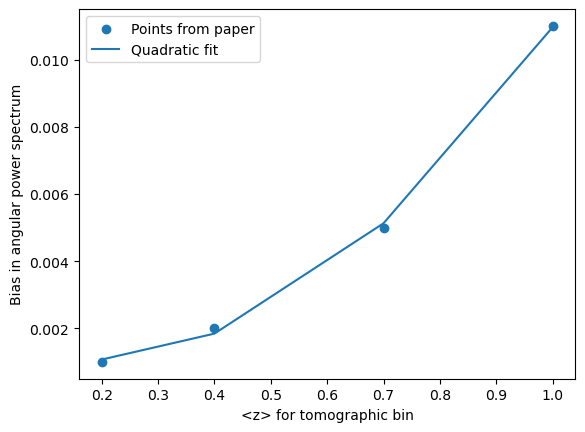

In [17]:
# Plot these to see what scaling of angular power spectrum bias with <z> seems about right.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(figure_9_mean_z, figure_9_Clbias, label='Points from paper')
fit_res = np.polyfit(figure_9_mean_z, figure_9_Clbias, 2)
poly_fit = np.poly1d(fit_res)
plt.plot(figure_9_mean_z, poly_fit(figure_9_mean_z), label='Quadratic fit')
plt.ylabel('Bias in angular power spectrum')
plt.legend()
plt.xlabel('<z> for tomographic bin')
plt.show()

In [31]:
# Now decide which of our bins to use -- let's not go more than 2*bin width 
# above the last point in the paper
max_z_use = np.max(figure_9_mean_z)+2*figure_9_width
use_bins = mean_z_values < max_z_use
print(max_z_use)
print(use_bins)

1.4
[ True  True  True  True False]


In [19]:
# For the bins we're using, get the angular power spectrum bias *for the specific mean-z scatter in the paper*
# Do this using our polynomial fit
mean_z_values_use = mean_z_values[use_bins]
Clbias = poly_fit(mean_z_values_use)
print(Clbias)

[0.00107087 0.00265354 0.0067874  0.01096063]


In [20]:
# Now rescale to account for our value of sigma_z, again using just a linear approximation for now.
rescale_fac = scatter_mean_z_values[use_bins] / figure_9_mean_z_scatter
print(rescale_fac)
Clbias *= rescale_fac
print(Clbias)


[1.5 1.5 1.5 1.5]
[0.0016063  0.00398031 0.0101811  0.01644094]


In [28]:
import meanz_modules as mzmod
import importlib
importlib.reload(mzmod)

clbias = mzmod.compute_Clbias(mean_z_values,scatter_mean_z_values,
                              figure_9_mean_z=np.array([0.2, 0.4, 0.7, 1.0]), 
                              figure_9_Clbias =np.array([1e-3, 2e-3, 5e-3, 1.1e-2]),
                              figure_9_width=0.2,figure_9_mean_z_scatter = 0.02)
print(clbias)

[ True  True  True  True False] use_bins
[0.00022658 0.00575052 0.01127447 0.01495709]


### Connect angular power spectrum biases to cosmology

We connect the above angular power spectrum biases as a function of redshift to cosmology using an approximate method from the DESC SRD.  In particular, in the DESC SRD we had found that if we do a full cosmological parameter fit to shear-shear, then dark energy measurements are especially susceptible to multiplicative bias in shear that is a function of redshift.  We therefore set requirements on that m(z) function, in particular on its slope.

Effectively, the above calculation shows that scatter in mean redshift across the survey that is not accounted for in the theory predictions also looks like a multiplicative bias.  So we're going to treat them like the same thing and apply the same requirement.

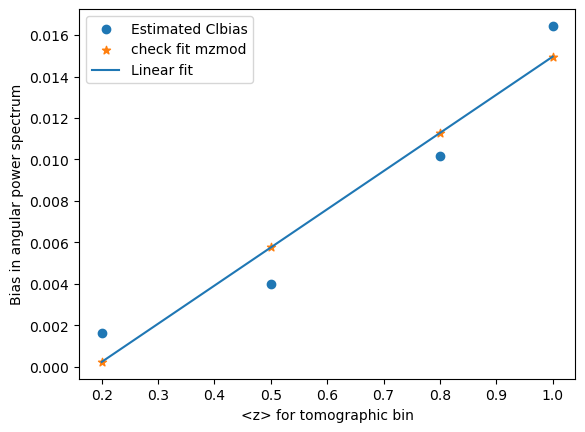

In [30]:
# Fit the above formula to a linear curve as in the DESC SRD when estimating this requirement.
fit_res_bias = np.polyfit(mean_z_values_use, Clbias, 1)
poly_fit_bias = np.poly1d(fit_res_bias)
# Then plot this
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(mean_z_values_use, Clbias, label='Estimated Clbias')
plt.scatter(mean_z_values_use, clbias, label='check fit mzmod', marker='*')
plt.plot(mean_z_values_use, poly_fit_bias(mean_z_values_use), label='Linear fit')
plt.ylabel('Bias in angular power spectrum')
plt.legend()
plt.xlabel('<z> for tomographic bin')
plt.show()

In [23]:
# Also account for difference in m vs. in Cell bias so we can tie the Cell bias to the m requirement.
# Generally the angular power spectrum goes like (1+m)^2 which, for m<<1, is (1+2m).  
# So the Cell bias in the above plot is basically 2m -> divide it by 2.
# Here we *are* going to use all bins, not just the ones we've used to derive this linear fit.
effective_m = poly_fit_bias(mean_z_values)/2.0
# We want to find m0, with is half of the total variation in effective m across our redshift range
m0 = 0.5*(np.max(effective_m) - np.min(effective_m))
print(effective_m, m0)

[0.00011329 0.00287526 0.00563723 0.00747855 0.01116118] 0.005523943435641967


In [24]:
# Finally, compare to our Y1 goals / Y10 requirements
y10_req = 0.003
y1_goal = 0.013
print('Year 1 goal on effective m is %f'%y1_goal)
print('Year 10 requirement on effective m is %f'%y10_req)
print('Estimate of effective m for this year and strategy due to redshift variation across the survey is %f'%m0)
if m0 < y10_req: print('An effect this small would not be a problem in any year.')
if m0 >= y1_goal: print('We would have to model an effect this large even in year 1.')
if m0 >= y10_req and m0 < y1_goal: print('We can ignore an effect of this size for year 1 but we would have to model it for year 10.')


Year 1 goal on effective m is 0.013000
Year 10 requirement on effective m is 0.003000
Estimate of effective m for this year and strategy due to redshift variation across the survey is 0.005524
We can ignore an effect of this size for year 1 but we would have to model it for year 10.
